# Code Violation in Kansas City

The residential code violation has become one of the most frequent reported concerns of the citizens among all reports in 311 City Action Center in Kansas City. This research is helping people understand more about the situation of code violation, and the cause and effects. I picked some questions from [the discussion](https://github.com/codeforkansascity/Property-Violations-Settlement/issues/27) that I feel curious about to address first.

Shih-Wen Su 2016/05/23

Related Links:

[Common Code Violations](http://kcmo.gov/neighborhoods/neighborhood-preservation/common-code-violations/)

[OpenData KC for Property Violation](https://data.kcmo.org/Housing/Property-Violations/nhtf-e75a)

[Code for Kansas City Property-Violation-Settlement](https://github.com/codeforkansascity/Property-Violations-Settlement)

## Where's the data?

Let's pull the data from [OpenData KC for Property Violation](https://data.kcmo.org/Housing/Property-Violations/nhtf-e75a)

In [1]:
# Code Preparation
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from IPython import display
%matplotlib inline

In [2]:
# Data Preparation
# There's a warning message for 'Inspection Area', as it's not all in integer
# We parse ['Case Opened Date', 'Case Closed Date', 'Violation Entry Date'] to be datetime object
def parse_date(x):
    if x in ['nan', '']:
        return None
    return datetime.strptime(str(x), '%m/%d/%Y')
df = pd.read_csv('Property_Violations.csv',
                    parse_dates=[3,4,10], date_parser=parse_date)
df.drop_duplicates(subset=['Case ID'])
print 'data size', df.shape

data size (427649, 21)


In [3]:
# Use only the data from 2009 to 2015
df = df[df['Case Opened Date'].dt.year.isin(range(2009,2016))]

In [4]:
# Let's look at the data size and columns
print df.shape
print df.dtypes

(415963, 21)
Property Violation ID               int64
Case ID                             int64
Status                             object
Case Opened Date           datetime64[ns]
Case Closed Date           datetime64[ns]
Days Open                         float64
Violation Code                     object
Violation Description              object
Ordinance Number                   object
Ordinance Chapter                   int64
Violation Entry Date       datetime64[ns]
Address                            object
County                             object
State                              object
Zip Code                          float64
KIVA PIN                            int64
Council District                  float64
Police Patrol Area                 object
Inspection Area                    object
Neighborhood                       object
Code Violation Location            object
dtype: object


## What day of week are violations most likely to be recorded?


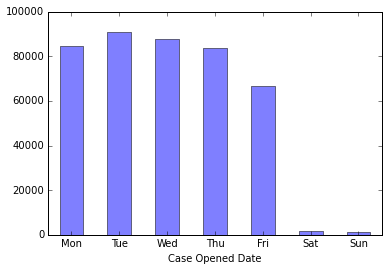

In [5]:
weekday_labels = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
def plot_by_weekday(col):
    g = df[col].groupby(df[col].dt.weekday).count().plot(kind="bar", alpha=0.5, ylim=(0,100000))
    g.set_xticklabels(weekday_labels, rotation=0)
    
plot_by_weekday('Case Opened Date')

## What day of week are violations most likely to be closed?

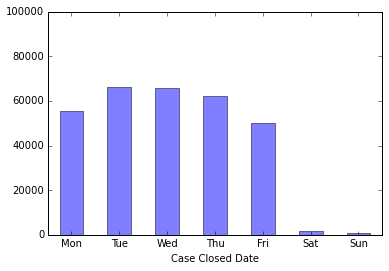

In [6]:
plot_by_weekday('Case Closed Date')

From the graph it seems nobody likes to report on the weekend, or, more likely, because no one would be on the other side of the phone to answer. We need to know the source of the records (from phone call or internet) to find out.

## What month are violations most likely to be recorded?

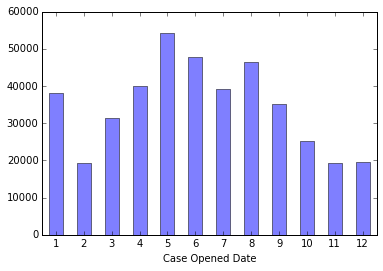

In [7]:
def plot_by_month(col):
    g = df[col].groupby(df[col].dt.month).count().plot(kind="bar", alpha=0.5, stacked=True, ylim=(0,60000))
    g.set_xticklabels(range(1,13), rotation=0)
plot_by_month('Case Opened Date')

## What month are violations most likely to be closed?

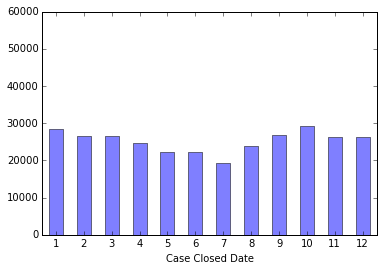

In [8]:
plot_by_month('Case Closed Date')

This is very interesting as there are more concerns reported during the summer season (May to August), but less cases are closed during this season.

Why is that? 

Are the concerns hard to deal with? 

Let's take a closer look at the code violations.

## What are the top violation types?

In [9]:
top_violations = df.groupby('Violation Code').size().nlargest(10)
print top_violations

Violation Code
NSWLTRASH     63933
NSWLWEED      50686
NSWLOPSTOR    44201
NSWLLIMBS     23770
NSEXTWAL06    20325
NSVACANT      19000
NSRENTAL01    14266
NSWLVEH02     12460
NSEXTWAL04    11821
NSWLWEED1     11276
dtype: int64


### Description of these top Violation Codes.

In [10]:
dfdesc = df[['Violation Code', 'Violation Description']]
dfdesc = dfdesc[dfdesc['Violation Code'].isin(top_violations.index)]
vdesc = dict(zip(dfdesc['Violation Code'].unique(), dfdesc['Violation Description'].unique()))
for i in top_violations.index:
    print "%12s: %s" % (i, vdesc[i])

   NSWLTRASH: LITTER, TRASH, REFUSE, AND RUBBISH
    NSWLWEED: RANK WEEDS OR UNATTENDED GROWTH
  NSWLOPSTOR: UNAPPROVED STORAGE
   NSWLLIMBS: LIMBS AND BRUSH
  NSEXTWAL06: PEELING, CRACKED, BLISTERED PAINT
    NSVACANT: FAILURE TO REGISTER VACANT PROPERTY
  NSRENTAL01: FAILURE TO REGISTER RENTAL DWELLING
   NSWLVEH02: UNLICENSED VEHICLE
  NSEXTWAL04: EXTERIOR SURFACE MATERIAL NOT PROTECTED
   NSWLWEED1: RANK WEEDS


## Which seasons correlate to higher frequencies of each type of violation?

[]

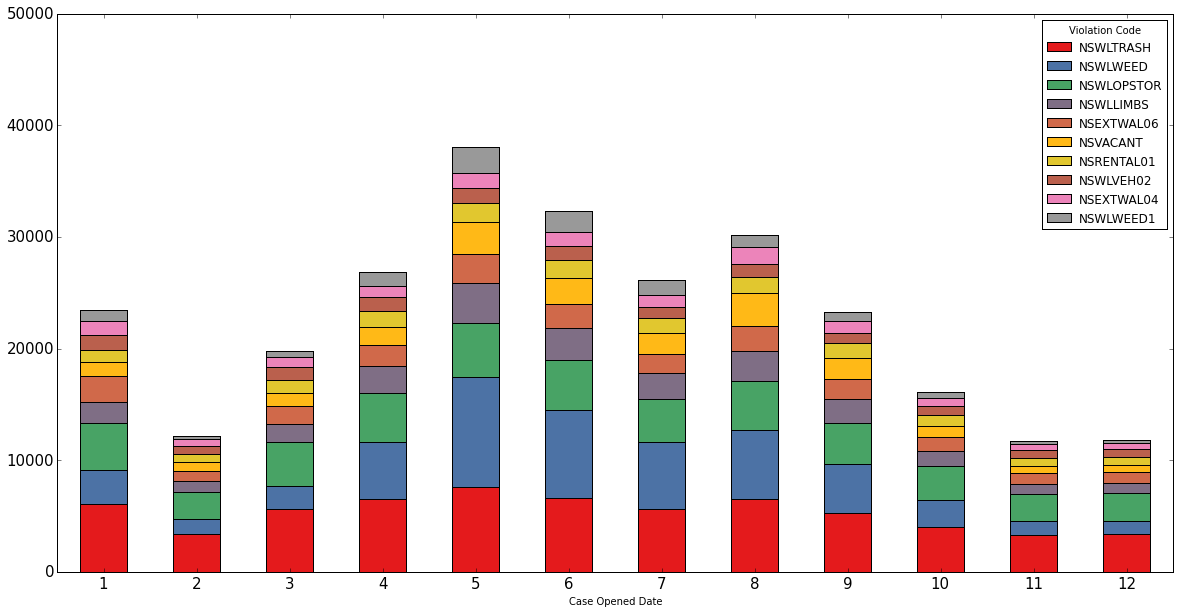

In [11]:
df2 = df[['Violation Code', 'Case Opened Date']]
df2 = df2[df2['Violation Code'].isin(top_violations.index)]
df2 = df2.groupby([df['Case Opened Date'].dt.month, 'Violation Code'])['Violation Code'].count().unstack().fillna(0)
df2 = df2[top_violations.index] #Use top violation index for Violation Code order
g = df2.plot(kind='bar',sort_columns=True, stacked=True, figsize=(20,10), fontsize=15, colormap='Set1', ylim=(0,50000))
g.set_xticklabels(range(1,13), rotation=0)
g.plot()


### Here we found NSWLWEED and NSWLWEED1 are very similar. 
### So what if we group violation sub-catagories together?

In [12]:
df['Violation Code Purged'] = df['Violation Code'].apply(lambda x: x.rstrip('1234567890.'))
top_violations_purged = df.groupby('Violation Code Purged').size().nlargest(10)
print top_violations_purged

Violation Code Purged
NSWLWEED      65250
NSWLTRASH     63933
NSEXTWAL      51834
NSWLOPSTOR    44201
NSWLVEH       26697
NSWLLIMBS     23770
NSVACANT      19000
NSRENTAL      14266
NSGUTTER      13783
NSEAVES       12486
dtype: int64


The weed family now becomes the top headache.

Let's take a look at the correlation again.

[]

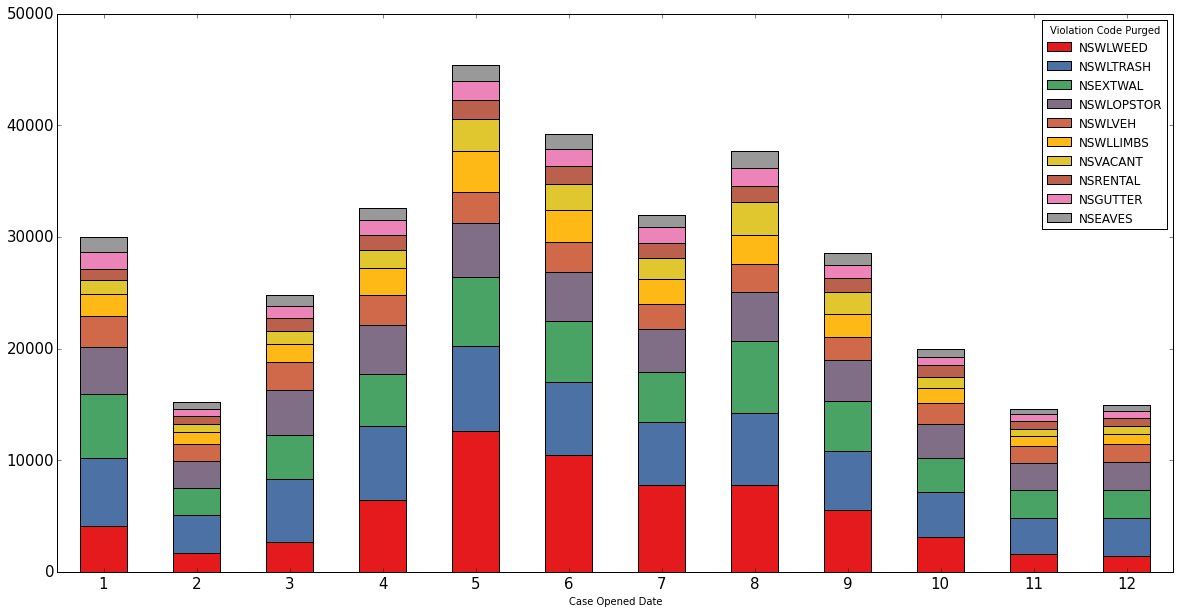

In [13]:
df2 = df[['Violation Code Purged', 'Case Opened Date']]
df2 = df2[df2['Violation Code Purged'].isin(top_violations_purged.index)]
df2 = df2.groupby([df['Case Opened Date'].dt.month, 'Violation Code Purged'])['Violation Code Purged'].count().unstack().fillna(0)
df2 = df2[top_violations_purged.index] #Use top violation index for Violation Code order
g = df2.plot(kind='bar',sort_columns=True, stacked=True, figsize=(20,10), fontsize=15, colormap='Set1', ylim=(0,50000))
g.set_xticklabels(range(1,13), rotation=0)
g.plot()

## How do the different types of violations affect how long a case takes to close?

In [25]:
df5 = df[['Violation Code Purged', 'Days Open']]
df5.groupby('Violation Code Purged').mean().sort_values(by='Days Open', ascending=False)[:20]

,Days Open
Violation Code Purged,
NSDBDEBRIS,994.000000
NSZFIRE,654.333333
NSCHIMNY,618.168357
NSEAVES,581.562640
NSXWLBRK,573.357143
NSXWLBKS,566.811024
NSFIRE,558.254237
NSXWLSTC,551.542857
NSRAIL,550.227677


It takes more than 500 days in average for these type of violation to be closed!

## What about open days for top violations?

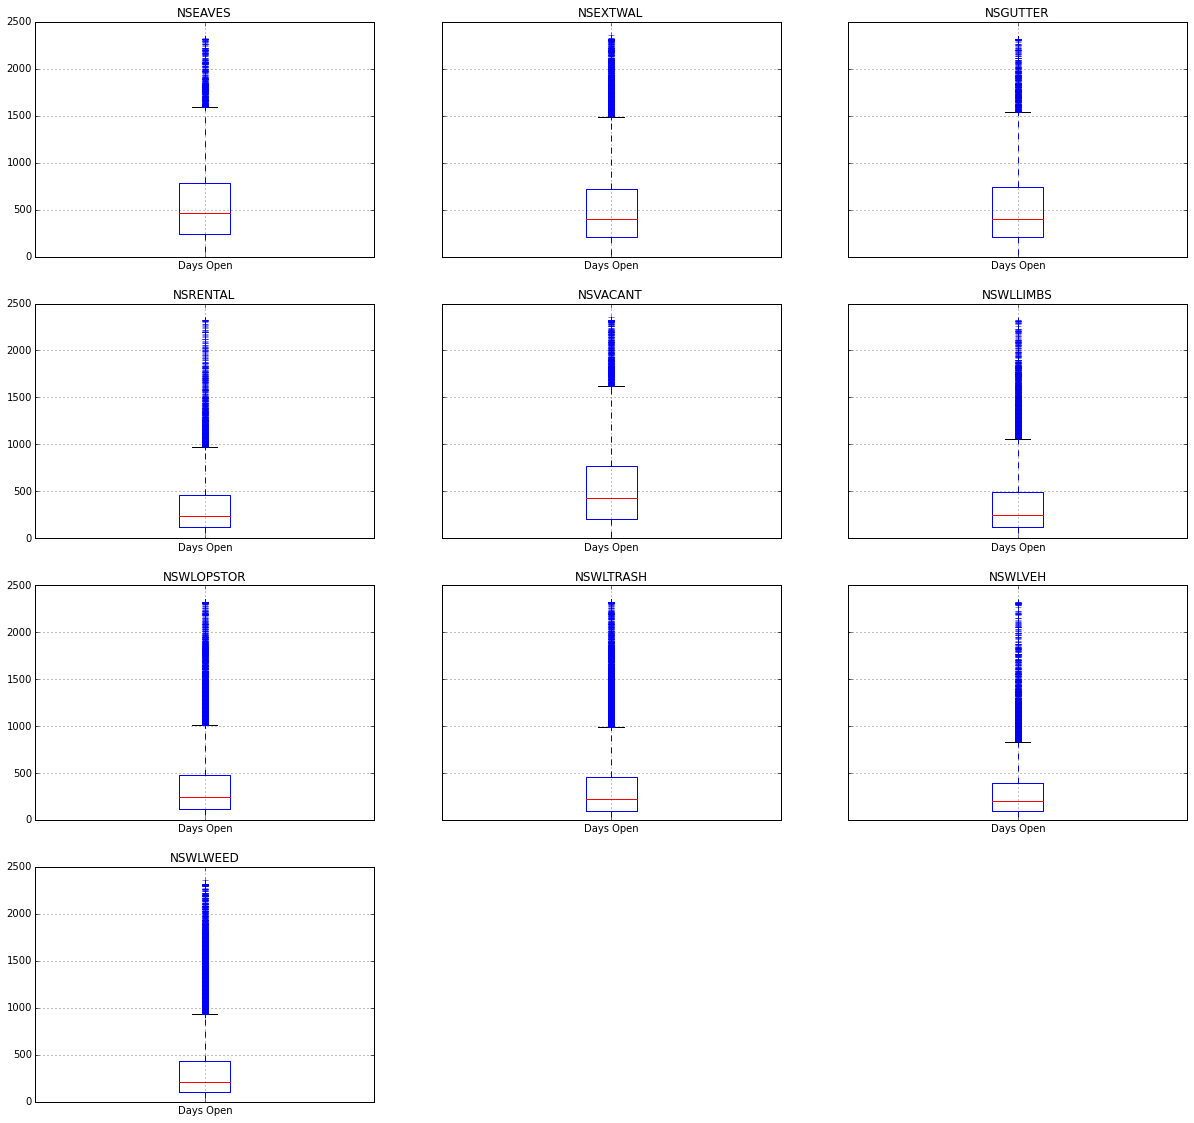

,Days Open
Violation Code Purged,
NSEAVES,581.562640
NSVACANT,539.848097
NSGUTTER,527.750653
NSEXTWAL,511.782428
NSWLLIMBS,369.721222
NSWLOPSTOR,355.793456
NSRENTAL,343.557145
NSWLTRASH,338.294880
NSWLWEED,336.051235


In [15]:
#How do the different types of violations among most reported violation types affect how long a case takes to close?
df5 = df[['Violation Code Purged', 'Days Open']]
df6 = df5[df5['Violation Code Purged'].isin(top_violations_purged.index)]
df6.groupby('Violation Code Purged').boxplot(figsize=(20,20))
plt.show()
df6.groupby('Violation Code Purged').mean().sort_values(by='Days Open', ascending=False)


It's hard to believe weed and trash violation takes about 336 days to be taken care of.

## What types of violations occur together?

This is another interesting question, but can be defined more specifically in many ways.

Here I want to know if several types of violation occur at the same location (same house).

In [16]:
#Violation happens at the same location
from itertools import combinations
dfto = df[['Violation Code', 'Code Violation Location']]
dftolsize = dfto.groupby('Code Violation Location').size()
mulcv_locations = dftolsize[dftolsize > 1].index
mdfto = dfto[dfto['Code Violation Location'].isin(mulcv_locations)] #contains locations with multiple cv reported
grouped = mdfto.groupby('Code Violation Location')
cooccur_dict = {}
for name, group in grouped:
    codes = group['Violation Code'].copy()
    for a, b in combinations(codes, 2):
        sorted_comb = sorted((a,b))
        k = " - ".join(sorted_comb)
        if cooccur_dict.has_key(k):
            cooccur_dict[k] += 1
        else:
            cooccur_dict[k] = 1
cooc = pd.DataFrame(cooccur_dict.items(), columns=["Violation Code Combos", "Co-occurance"])
cooc.nlargest(20, "Co-occurance").reset_index(drop=True)

,Violation Code Combos,Co-occurance
0,NSWLOPSTOR - NSWLTRASH,124637
1,NSWLTRASH - NSWLWEED,111015
2,NSWLTRASH - NSWLTRASH,74785
3,NSWLOPSTOR - NSWLWEED,62981
4,NSWLLIMBS - NSWLTRASH,56751
5,NSWLWEED - NSWLWEED,50636
6,NSVACANT - NSWLTRASH,50448
7,NSWLLIMBS - NSWLWEED,47897
8,NSVACANT - NSWLWEED,47522
9,NSEXTWAL06 - NSWLTRASH,44626


It's not a big surprise these types of code violation occur together the most.

NSWLTRASH: LITTER, TRASH, REFUSE, AND RUBBISH

  NSWLWEED: RANK WEEDS OR UNATTENDED GROWTH
  
NSWLOPSTOR: UNAPPROVED STORAGE

But let's take a look at 3 violation combos.

In [17]:
# 3 Combos
grouped = mdfto.groupby('Code Violation Location')
cooccur_dict = {}
for name, group in grouped:
    codes = group['Violation Code'].copy()
    for a, b, c in combinations(codes, 3):
        sorted_comb = sorted((a,b,c))
        k = " - ".join(sorted_comb)
        if cooccur_dict.has_key(k):
            cooccur_dict[k] += 1
        else:
            cooccur_dict[k] = 1
cooc = pd.DataFrame(cooccur_dict.items(), columns=["Violation Code Combos", "Co-occurance"])
cooc.nlargest(20, "Co-occurance").reset_index(drop=True)

,Violation Code Combos,Co-occurance
0,NSWLOPSTOR - NSWLTRASH - NSWLTRASH,315634
1,NSWLOPSTOR - NSWLOPSTOR - NSWLTRASH,283078
2,NSWLOPSTOR - NSWLTRASH - NSWLWEED,271425
3,NSWLTRASH - NSWLTRASH - NSWLWEED,204788
4,NSWLTRASH - NSWLWEED - NSWLWEED,168344
5,NSVACANT - NSWLTRASH - NSWLWEED,167930
6,NSWLLIMBS - NSWLTRASH - NSWLWEED,167143
7,NSWLLIMBS - NSWLOPSTOR - NSWLTRASH,150512
8,NSEXTWAL06 - NSWLOPSTOR - NSWLTRASH,135780
9,NSWLOPSTOR - NSWLTRASH - NSWLVEH02,126991


## Does a presence of a certain type of violation predict another one? 

Even after we know certain types of violation occur together, it's interesting to see if there's a consequense between different types of violation.

In [23]:
# Violation presence and consequences
from itertools import combinations, product
dftod = df[['Violation Code', 'Code Violation Location', 'Case Opened Date']]
dftodlsize = dftod.groupby('Code Violation Location').size()
dftodlsize
mulcv_locations = dftodlsize[dftodlsize > 1].index
mdfto = dftod[dftod['Code Violation Location'].isin(mulcv_locations)] #contains locations with multiple cv reported
grouped = mdfto.groupby(['Code Violation Location'])
progress = 0 
cooccur_dict = {}
for name, group in grouped:
    if len(group['Case Opened Date'].unique()) > 1:
        #reported in multiple dates
        codes_sequences = [g['Violation Code'] for n, g in group.groupby('Case Opened Date')][:6]
        #produce all combination
        for code_sequence in list(product(*codes_sequences)):
            k = " -> ".join(code_sequence)
            if cooccur_dict.has_key(k):
                cooccur_dict[k] += 1
            else:
                cooccur_dict[k] = 1
    progress += 1
    if progress % 1000 == 0: 
        print '=',
#     if dead > 50000: break
cooc = pd.DataFrame(cooccur_dict.items(), columns=["Violation Effects", "Occurance"])
cooc.nlargest(30, "Occurance").reset_index(drop=True)

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =

,Violation Effects,Occurance
0,NSWLTRASH -> NSWLTRASH,8239
1,NSWLTRASH -> NSWLOPSTOR,6186
2,NSWLOPSTOR -> NSWLTRASH,5424
3,NSWLTRASH -> NSWLWEED,5112
4,NSWLOPSTOR -> NSWLOPSTOR,5100
5,NSWLWEED -> NSWLWEED,5012
6,NSWLWEED -> NSWLTRASH,4519
7,NSWLOPSTOR -> NSWLWEED,3055
8,NSWLTRASH -> NSWLTRASH -> NSWLTRASH,3042
9,NSWLWEED -> NSWLOPSTOR,2960


From this analysis, we can see the trash violation can be a sign of many other violations. Also, we can find many violation types occur repeatedly at the same spot.

NSWLTRASH -> NSWLTRASH	8239

NSWLOPSTOR -> NSWLOPSTOR	5100

NSWLWEED -> NSWLWEED	5012

NSWLTRASH -> NSWLTRASH -> NSWLTRASH	3042

NSWLWEED -> NSWLWEED -> NSWLWEED	1861

Does this mean the same violation tends to occur at some hotspots, e.g., people like to go to the same place for illegal dumping, or does this mean there's a failing recovery system not responding to reported issues timely enough for residents' expectation, and as a result people keep reporting the same issues? Well, based on the open days of the violation revealed above, we can make a good guess.